# Machine Learning with PyTorch and Scikit-Learn  


# Chapter 11 - Implementing a Multi-layer Artificial Neural Network from Scratch


### Overview

- [Modeling complex functions with artificial neural networks](#Modeling-complex-functions-with-artificial-neural-networks)
  - [Single-layer neural network recap](#Single-layer-neural-network-recap)
  - [Introducing the multi-layer neural network architecture](#Introducing-the-multi-layer-neural-network-architecture)
  - [Activating a neural network via forward propagation](#Activating-a-neural-network-via-forward-propagation)
- [Classifying handwritten digits](#Classifying-handwritten-digits)
  - [Obtaining the MNIST dataset](#Obtaining-the-MNIST-dataset)
  - [Implementing a multi-layer perceptron](#Implementing-a-multi-layer-perceptron)
  - [Coding the neural network training loop](#Coding-the-neural-network-training-loop)
  - [Evaluating the neural network performance](#Evaluating-the-neural-network-performance)
- [Training an artificial neural network](#Training-an-artificial-neural-network)
  - [Computing the loss function](#Computing-the-loss-function)
  - [Developing your intuition for backpropagation](#Developing-your-intuition-for-backpropagation)
  - [Training neural networks via backpropagation](#Training-neural-networks-via-backpropagation)
- [Convergence in neural networks](#Convergence-in-neural-networks)
- [Summary](#Summary)

<br>
<br>

In [60]:
from IPython.display import Image
%matplotlib inline

# Modeling complex functions with artificial neural networks

...

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [61]:
!pip install openml


In [62]:
from tensorflow.keras.datasets import mnist
import numpy as np

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten the images (28x28 -> 784) to match the shape of `fetch_openml` output
X_train = X_train.reshape(-1, 28 * 28).astype(float)
X_test = X_test.reshape(-1, 28 * 28).astype(float)

# Combine train and test sets to mimic `fetch_openml` structure
X = np.vstack((X_train, X_test))
y = np.hstack((y_train, y_test))

print(X.shape)  # Should print (70000, 784)
print(y.shape)  # Should print (70000,)

##### The originl load for the data set didn't worked for me so I changed the way of loading (loads the same dataset) ###

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [63]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

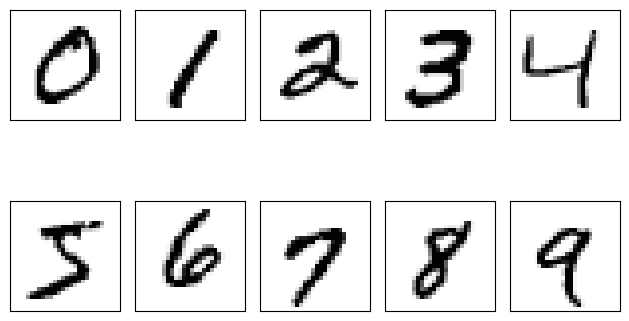

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

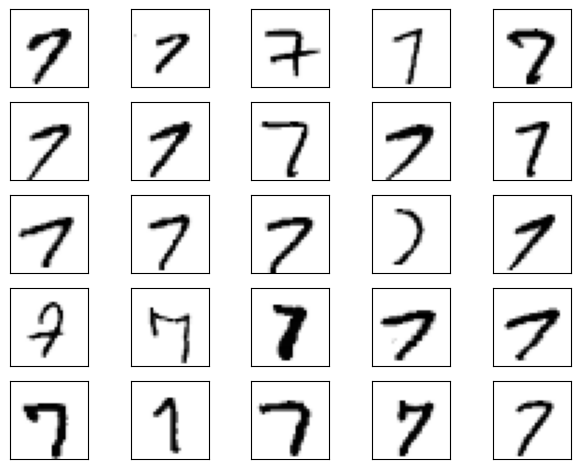

In [65]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [66]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

<br>
<br>

## Implementing a multi-layer perceptron

In [67]:
import numpy as np

In [68]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden1, num_hidden2, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        rng = np.random.RandomState(random_seed)

        # First hidden layer
        self.weight_h1 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden1, num_features))
        self.bias_h1 = np.zeros(num_hidden1)

        # Second hidden layer
        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden2, num_hidden1))
        self.bias_h2 = np.zeros(num_hidden2)

        # Output layer
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # First hidden layer
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Second hidden layer
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)

        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out)
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        d_z_out__d_w_out = a_h2
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__d_w_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHidden2Weights
        d_z_out__a_h2 = self.weight_out
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2)
        delta_h2 = d_loss__a_h2 * d_a_h2__d_z_h2

        d_z_h2__d_w_h2 = a_h1
        d_loss__d_w_h2 = np.dot(delta_h2.T, d_z_h2__d_w_h2)
        d_loss__d_b_h2 = np.sum(delta_h2, axis=0)

        #################################
        # Part 3: dLoss/dHidden1Weights
        d_z_h2__a_h1 = self.weight_h2
        d_loss__a_h1 = np.dot(delta_h2, d_z_h2__a_h1)
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1)
        delta_h1 = d_loss__a_h1 * d_a_h1__d_z_h1

        d_z_h1__d_w_h1 = x
        d_loss__d_w_h1 = np.dot(delta_h1.T, d_z_h1__d_w_h1)
        d_loss__d_b_h1 = np.sum(delta_h1, axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h2, d_loss__d_b_h2,
                d_loss__d_w_h1, d_loss__d_b_h1)

In [69]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden1=50,  # First hidden layer size
                     num_hidden2=30,  # Second hidden layer size
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [70]:
import numpy as np
from sklearn.model_selection import train_test_split

# Perform 70/30 Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]

# Iterate over training epochs
for i in range(num_epochs):

    # Generate minibatches from the Train split
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break  # Only for demonstration purposes

    break  # Only for demonstration purposes

# Print the shape of the first minibatch
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [71]:
from sklearn.metrics import roc_auc_score

def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


# Forward pass to get probabilities on the Test split
_, _, probas = model.forward(X_test)  # Adjusted for two hidden layers

# Compute Mean Squared Error
mse = mse_loss(y_test, probas)

# Compute accuracy
predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_test, predicted_labels)

# Compute Macro AUC
macro_auc = roc_auc_score(
    int_to_onehot(y_test, num_labels=10), probas, multi_class='ovr')

# Print results
print(f'Test MSE: {mse:.1f}')
print(f'Test accuracy: {acc*100:.1f}%')
print(f'Test Macro AUC: {macro_auc:.3f}')


Test MSE: 0.2
Test accuracy: 9.1%
Test Macro AUC: 0.537


In [72]:
from sklearn.metrics import roc_auc_score

def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    all_targets = []
    all_probas = []
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        # Forward pass with updated NeuralNetMLP
        _, _, probas = nnet.forward(features)  # Adjusted for two hidden layers

        # Predicted labels and loss calculation
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)

        # Track correct predictions and examples
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss

        # Store probabilities and targets for macro AUC
        all_targets.append(targets)
        all_probas.append(probas)

    # Combine all targets and probabilities
    all_targets = np.concatenate(all_targets)
    all_probas = np.vstack(all_probas)

    # Compute average MSE and accuracy
    mse = mse / (i + 1)
    acc = correct_pred / num_examples

    # Compute Macro AUC
    macro_auc = roc_auc_score(
        int_to_onehot(all_targets, num_labels=num_labels), all_probas, multi_class='ovr')

    return mse, acc, macro_auc

In [73]:
mse, acc, macro_auc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test MSE: {mse:.1f}')
print(f'Test accuracy: {acc*100:.1f}%')
print(f'Test Macro AUC: {macro_auc:.3f}')

Test MSE: 0.2
Test accuracy: 9.1%
Test Macro AUC: 0.537


In [74]:
def train(model, X_train, y_train, X_test, y_test, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_test_acc = []
    epoch_macro_auc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)  # Adjusted for two hidden layers

            #### Compute gradients ####
            (d_loss__d_w_out, d_loss__d_b_out,
             d_loss__d_w_h2, d_loss__d_b_h2,
             d_loss__d_w_h1, d_loss__d_b_h1) = \
                model.backward(X_train_mini, a_h1, a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc, _ = compute_mse_and_acc(model, X_train, y_train)  # Ignoring macro_auc for training
        test_mse, test_acc, macro_auc = compute_mse_and_acc(model, X_test, y_test)  # Using all values for Test
        train_acc, test_acc = train_acc * 100, test_acc * 100

        epoch_train_acc.append(train_acc)
        epoch_test_acc.append(test_acc)
        epoch_macro_auc.append(macro_auc)
        epoch_loss.append(train_mse)

        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Test Acc: {test_acc:.2f}% '
              f'| Macro AUC: {macro_auc:.3f}')


    return epoch_loss, epoch_train_acc, epoch_test_acc, epoch_macro_auc

In [75]:
np.random.seed(123)  # For consistent training set shuffling

epoch_loss, epoch_train_acc, epoch_test_acc, epoch_macro_auc = train(
    model, X_train, y_train, X_test, y_test,
    num_epochs=50, learning_rate=0.1)


Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 16.09% | Test Acc: 15.98% | Macro AUC: 0.717
Epoch: 002/050 | Train MSE: 0.09 | Train Acc: 21.50% | Test Acc: 21.18% | Macro AUC: 0.818
Epoch: 003/050 | Train MSE: 0.08 | Train Acc: 29.05% | Test Acc: 28.91% | Macro AUC: 0.859
Epoch: 004/050 | Train MSE: 0.07 | Train Acc: 36.80% | Test Acc: 36.94% | Macro AUC: 0.879
Epoch: 005/050 | Train MSE: 0.06 | Train Acc: 56.53% | Test Acc: 56.49% | Macro AUC: 0.911
Epoch: 006/050 | Train MSE: 0.05 | Train Acc: 65.24% | Test Acc: 65.31% | Macro AUC: 0.933
Epoch: 007/050 | Train MSE: 0.04 | Train Acc: 73.98% | Test Acc: 74.00% | Macro AUC: 0.948
Epoch: 008/050 | Train MSE: 0.04 | Train Acc: 81.89% | Test Acc: 81.79% | Macro AUC: 0.962
Epoch: 009/050 | Train MSE: 0.03 | Train Acc: 85.69% | Test Acc: 85.65% | Macro AUC: 0.970
Epoch: 010/050 | Train MSE: 0.03 | Train Acc: 87.22% | Test Acc: 86.93% | Macro AUC: 0.975
Epoch: 011/050 | Train MSE: 0.02 | Train Acc: 88.30% | Test Acc: 88.14% | Macro AUC: 0.978

## Evaluating the neural network performance

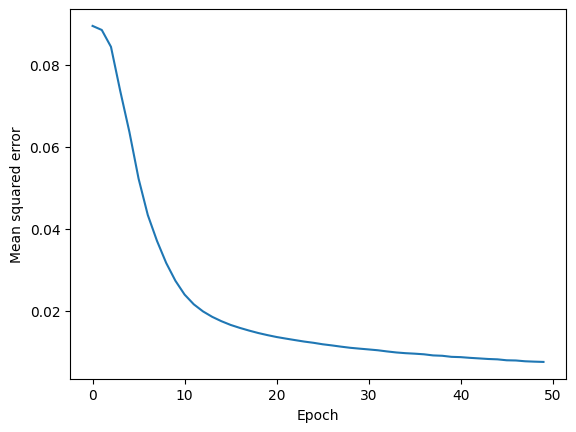

In [76]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

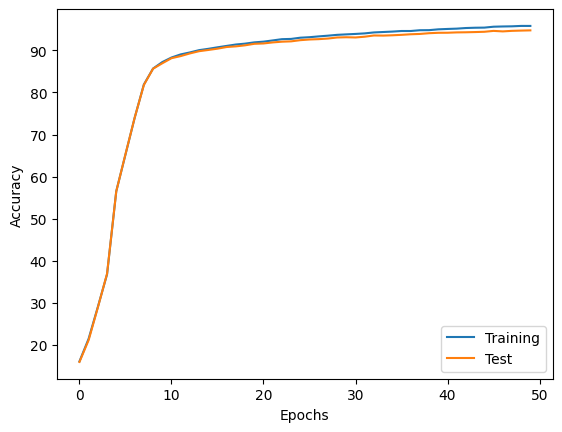

In [77]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_test_acc)), epoch_test_acc,
         label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()


In [78]:
test_mse, test_acc, macro_auc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test MSE: {test_mse:.1f}')
print(f'Test accuracy: {test_acc*100:.2f}%')
print(f'Test Macro AUC: {macro_auc:.3f}')

Test MSE: 0.0
Test accuracy: 94.76%
Test Macro AUC: 0.994


Plot failure cases:

In [79]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

# Forward pass with updated NeuralNetMLP
_, _, probas = model.forward(X_test_subset)  # Adjusted for two hidden layers

# Predictions
test_pred = np.argmax(probas, axis=1)

# Extract misclassified images and labels
misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

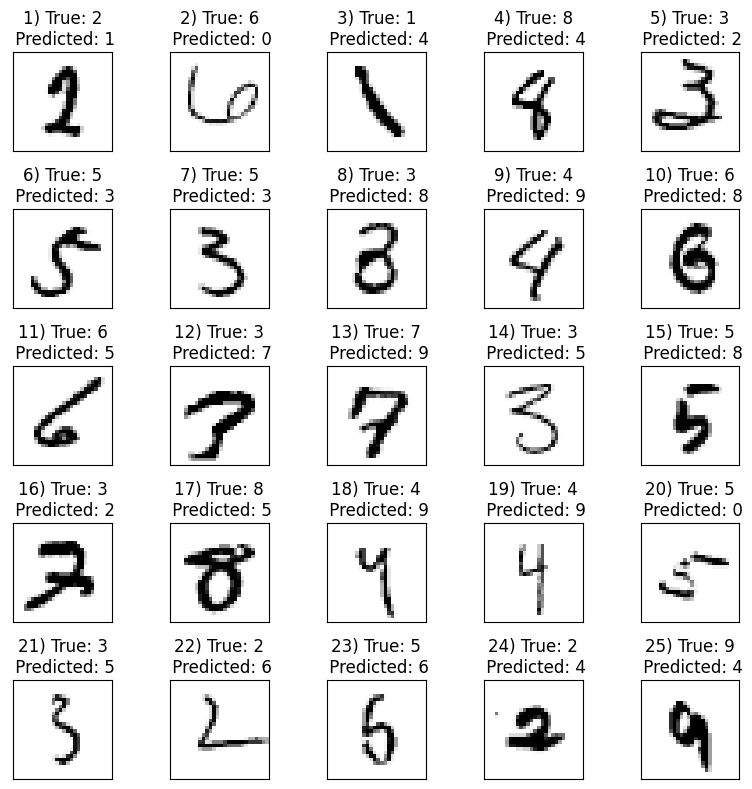

In [80]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

<br>
<br>